In [20]:
import numpy as np
import pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env import generate_random_act, MaterialEnvironment, extract_data_from_ep
import collections
from sklearn.preprocessing import StandardScaler
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Random policy

In [39]:
# Load Q_data_random
with open('./data/Q_data_random.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_data_random))

Number of episodes generated by random policy: 10000


In [40]:
s_material_inputs = []
s_step_inputs     = []
a_elem_inputs     = []
a_comp_inputs     = []
Q_targets         = []

for episode in Q_data_random:
    for step in episode:
        # state, action, reward = step
        [s_material, s_step], [a_elem, a_comp], Q_target = step

        s_material = torch.tensor(s_material).float()
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)

s_material_inputs = torch.stack(s_material_inputs)
s_step_inputs = torch.stack(s_step_inputs)
a_elem_inputs = torch.stack(a_elem_inputs)
a_comp_inputs = torch.stack(a_comp_inputs)
Q_targets = torch.stack(Q_targets)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('')

s_material_inputs: torch.Size([50000, 145])
s_step_inputs: torch.Size([50000, 5])
a_elem_inputs: torch.Size([50000, 80])
a_comp_inputs: torch.Size([50000, 10])
Q_targets: torch.Size([50000, 1])



/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


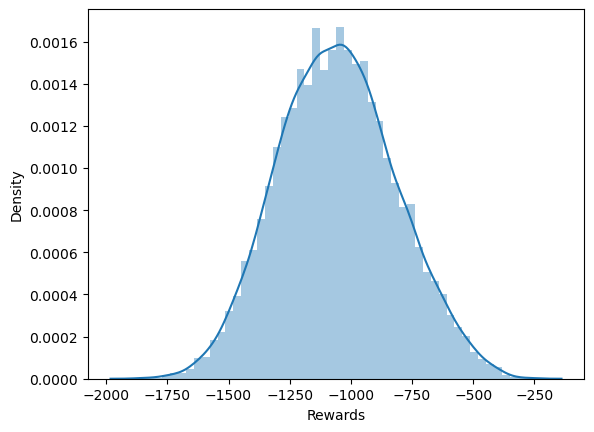

In [41]:
# Plot distribution of final rewards by random policy
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.distplot(final_rewards_random)
plt.xlabel('Rewards')
plt.show()

# Training Q-network with random policy data

In [48]:
# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float()
print('after scaling:', s_material_inputs_scaled)

before: tensor([[4.0000, 0.5677, 0.4946,  ..., 0.0000, 0.7018, 0.0688],
        [3.0000, 0.6236, 0.5503,  ..., 0.0000, 0.7018, 0.0955],
        [2.0000, 0.7906, 0.7591,  ..., 0.0000, 0.3960, 0.0742],
        ...,
        [2.0000, 0.7071, 0.6300,  ..., 1.0000, 0.7515, 0.1879],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after: tensor([[ 1.6800, -0.0780, -0.1854,  ..., -0.5575,  2.9411,  1.2529],
        [ 0.9245,  0.0806, -0.0260,  ..., -0.5575,  2.9411,  1.9780],
        [ 0.1691,  0.5546,  0.5709,  ..., -0.5575,  1.3728,  1.4003],
        ...,
        [ 0.1691,  0.3176,  0.2017,  ...,  1.7938,  3.1960,  4.4879],
        [-0.5863,  1.1491,  1.2593,  ...,  1.7938, -0.6575, -0.6167],
        [-1.3418, -1.6897, -1.5989,  ..., -0.5575, -0.6575, -0.6167]])


In [50]:
# Train-validation split
valid_size = 0.2
max_idx = s_material_inputs.shape[0] # Find size of dataset
idx = [x for x in range(max_idx)] # Generate indices
random.shuffle(idx) # Shuffle order idx 
split = int(round(max_idx*(1-valid_size)))
train_idx, valid_idx = idx[:split], idx[split:] # Split indices

s_material_inputs_train = s_material_inputs_scaled[train_idx] # Use scaled s_material
s_step_inputs_train     = s_step_inputs[train_idx]
a_elem_inputs_train     = a_elem_inputs[train_idx]
a_comp_inputs_train     = a_comp_inputs[train_idx]
Q_targets_train         = Q_targets[train_idx]

s_material_inputs_valid = s_material_inputs_scaled[valid_idx] # Use scaled s_material
s_step_inputs_valid     = s_step_inputs[valid_idx]
a_elem_inputs_valid     = a_elem_inputs[valid_idx]
a_comp_inputs_valid     = a_comp_inputs[valid_idx]
Q_targets_valid         = Q_targets[valid_idx]

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)

TRAIN:
s_material_inputs_train: torch.Size([40000, 145])
s_step_inputs_train: torch.Size([40000, 5])
a_elem_inputs_train: torch.Size([40000, 80])
a_comp_inputs_train: torch.Size([40000, 10])
Q_targets_train: torch.Size([40000, 1])

VALIDATION:
s_material_inputs_valid: torch.Size([10000, 145])
s_step_inputs_valid: torch.Size([10000, 5])
a_elem_inputs_valid: torch.Size([10000, 80])
a_comp_inputs_valid: torch.Size([10000, 10])
Q_targets_valid: torch.Size([10000, 1])


In [51]:
# Initialize Q network
train_loss_list = []
valid_loss_list = []

dqn = DQN_pytorch()

# Train Q network
optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
loss_func = torch.nn.SmoothL1Loss().float()

start = time.time()

num_epoch = 100

for epoch in range(num_epoch):
    # Train loss
    prediction_train = dqn(s_material = s_material_inputs_train, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                    )                    # Input x and predict based on x
    train_loss       = loss_func(prediction_train.float(), Q_targets_train.float()).float()   # Must be (1. nn output, 2. target)
    optimizer.zero_grad()   # Clear gradients for next train
    train_loss.backward()         # Backpropagation, compute gradients
    optimizer.step()        # Apply gradients

    # Validation loss
    prediction_valid = dqn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                    )
    valid_loss = loss_func(prediction_valid.float(), Q_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
    train_loss_list.append(train_loss.detach().numpy())
    valid_loss_list.append(valid_loss.detach().numpy())

    print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.data.numpy(), 'Valid_loss = %.4f' % valid_loss.data.numpy())
end = time.time()
print('time taken for batch:', end - start)

Epoch =  0 Train_loss = 863.5796 Valid_loss = 865.7327
Epoch =  1 Train_loss = 862.5138 Valid_loss = 863.7603
Epoch =  2 Train_loss = 860.5452 Valid_loss = 860.3820
Epoch =  3 Train_loss = 857.1761 Valid_loss = 855.2114
Epoch =  4 Train_loss = 852.0220 Valid_loss = 847.8276
Epoch =  5 Train_loss = 844.6642 Valid_loss = 837.7734
Epoch =  6 Train_loss = 834.6467 Valid_loss = 824.5490
Epoch =  7 Train_loss = 821.4736 Valid_loss = 807.6015
Epoch =  8 Train_loss = 804.5950 Valid_loss = 786.3304
Epoch =  9 Train_loss = 783.4129 Valid_loss = 760.0751
Epoch =  10 Train_loss = 757.2713 Valid_loss = 728.1234
Epoch =  11 Train_loss = 725.4690 Valid_loss = 689.7712
Epoch =  12 Train_loss = 687.2657 Valid_loss = 644.4369
Epoch =  13 Train_loss = 642.0810 Valid_loss = 592.1517
Epoch =  14 Train_loss = 589.9678 Valid_loss = 534.6235
Epoch =  15 Train_loss = 532.9036 Valid_loss = 478.6260
Epoch =  16 Train_loss = 477.3614 Valid_loss = 434.1050
Epoch =  17 Train_loss = 433.4019 Valid_loss = 400.8322
Ep

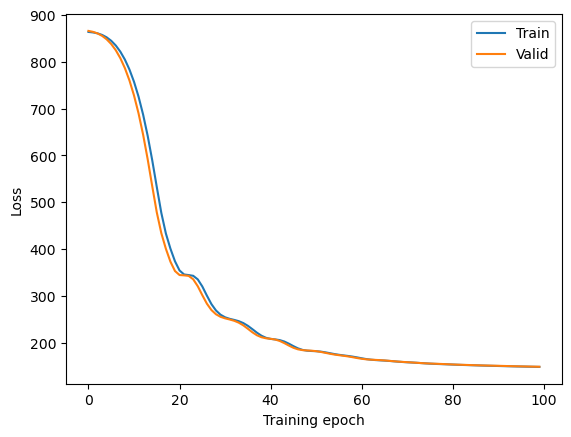

In [52]:
# Plot train and valid losses
plt.figure()
plt.plot(range(0,num_epoch), train_loss_list, label = 'Train')
plt.plot(range(0,num_epoch), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [94]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set)):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    1st index corresponds to highest Q-value
    """

    s_material, s_step = state
    # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
    s_material = torch.tensor(scaler.transform(s_material)).reshape(-1).float()  # Standardize s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    s_material_input = torch.stack([s_material]*n_actions)
    s_step_input = torch.stack([s_step]*n_actions)

    a_elem_input = []
    a_comp_input = []
    for elem in element_set:
        a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
        for comp in comp_set:
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float()
    a_comp_input = torch.stack(a_comp_input).float()
    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.detach().numpy()
    Q_pred = Q_pred.reshape(len(element_set)*len(comp_set))
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(element_set)])
    a_comp_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(comp_set)])
    Q_pred_ranked = np.zeros(len(element_set)*len(comp_set))

    for rank in reversed(range(len(element_set)*len(comp_set))): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (len(element_set)*len(comp_set) - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_comp according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print('Max Q: ', max(Q_pred_ranked))
    # print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked

mat_1 = 'BaTiO3'
mat_2 = 'SrTiO3'

print('Based on {}:'.format(mat_1))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_1, 1], dqn = dqn)
print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))
print('')

print('Based on {}:'.format(mat_2))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_2, 1], dqn = dqn)
print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))

Based on BaTiO3:
tensor([[3.0000e+00, 6.6332e-01, 6.1446e-01, 6.0098e-01, 6.0008e-01, 6.0000e-01,
         8.0000e+00, 5.6000e+01, 4.8000e+01, 2.0400e+01, 1.4880e+01, 8.0000e+00,
         9.0000e+00, 8.7000e+01, 7.8000e+01, 6.2600e+01, 2.9280e+01, 8.7000e+01,
         1.5999e+01, 1.3733e+02, 1.2133e+02, 4.6638e+01, 3.6767e+01, 1.5999e+01,
         5.4800e+01, 1.9410e+03, 1.8862e+03, 6.2108e+02, 6.7954e+02, 5.4800e+01,
         2.0000e+00, 1.6000e+01, 1.4000e+01, 1.0800e+01, 6.2400e+00, 1.6000e+01,
         2.0000e+00, 6.0000e+00, 4.0000e+00, 3.2000e+00, 1.4400e+00, 2.0000e+00,
         6.6000e+01, 2.1500e+02, 1.4900e+02, 1.1460e+02, 5.8320e+01, 6.6000e+01,
         8.9000e-01, 3.4400e+00, 2.5500e+00, 2.5500e+00, 1.0680e+00, 3.4400e+00,
         2.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00,
         0.0000e+00, 4.0000e+00, 4.0000e+00, 2.4000e+00, 1.9200e+00, 4.0000e+00,
         0.0000e+00, 2.0000e+00, 2.0000e+00, 4.0000e-01, 6.4000e-01, 0.0000e+00,
         0.

In [73]:
# Investigate weights of dqn
dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),

(tensor(0.0003, grad_fn=<MeanBackward0>),
 tensor(0.1834, grad_fn=<MeanBackward0>),
 tensor(0.3197, grad_fn=<MeanBackward0>),
 tensor(0.3407, grad_fn=<MeanBackward0>))

In [84]:
# s_material = torch.tensor(onehot_target('BaTiO3'))
s_material = torch.tensor(scaler.transform(torch.tensor(featurize_target('BaTiO3')).reshape(1,-1))).float()
# s_material = s_material.reshape(1, s_material.shape[0])
# print(s_material.shape)

s_step = torch.zeros(5)
s_step[3] = 1.
s_step = s_step.reshape(1, s_step.shape[0])
# print(s_step.shape)

a_elem = torch.zeros(80)
a_elem[2] = 1.
a_elem = a_elem.reshape(1, a_elem.shape[0])
# print(a_elem.shape)

a_comp = torch.zeros(10)
a_comp[1] = 1.
a_comp = a_comp.reshape(1, a_comp.shape[0])
# print(a_comp.shape)

output = dqn(s_material, s_step, a_elem, a_comp)
print(output)
# print(output.shape)

tensor([[-1019.5943]], grad_fn=<AddmmBackward>)


In [76]:
env = MaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,)

def generate_max_act(state, dqn, stochastic_top_frac = 0):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    
    tot_num_actions = len(a_elem_input_ranked)
    if stochastic_top_frac != 0: # if stochastic
        act_idx = stochastic_top_frac*tot_num_actions # cut-off index
        rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
    else: # deterministic
        rank = 0 # take top action (index 0)
    max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_ep_with_dqn(dqn, max_steps = 5, epsilon = 0, stochastic_top_frac = 0):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    max_steps: Int
    epsilon: Float. Probability of taking random action 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    
    '''
    env.initialize()

    for i in range(max_steps):
        # if i == 0: # if start of episode, choose random first element #########################
        #     action = generate_random_act()

        # else: # elif not start of episode, take greedy action
        #     # Max action
        #     action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn)
        if np.random.uniform(0,1) > epsilon:
            action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn, stochastic_top_frac = stochastic_top_frac)
        else:
            action = generate_random_act()
        # Take step with action
        env.step(action)
        print('step:', env.counter)
        print('state:',env.state)
        print('reward:',env.reward())
        # print(env.num_steps_taken)
        print('')
    return env.path
generate_ep_with_dqn(dqn = dqn)

step: 1
state: Se6
reward: 0

step: 2
state: Se6Se6
reward: 0

step: 3
state: Se6Se6Se6
reward: 0

step: 4
state: Se6Se6Se6Se6
reward: 0

step: 5
state: Se6Se6Se6Se6Se6
reward: -982.15704



[([[0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,

In [80]:
# ========= FOR TRAINED POLICY ===========
start = time.time()
#Generate episodes with DQN
num_eps = 100
episodes = []
for j in range(num_eps):
    episode = generate_ep_with_dqn(dqn, max_steps = 5, epsilon = 0, stochastic_top_frac = 0)
    episodes.append(episode)

Q_data_trained = []
# Extract Q_data from episodes
for episode in episodes:
    Q_data = extract_data_from_ep(episode)
    Q_data_trained.append(Q_data)
end = time.time()
print('time taken:', end - start)

# Save Q_data
with open('./data/Q_data_trained.pkl', 'wb') as f:
    pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

step: 1
state: Se6
reward: 0

step: 2
state: Se6Se6
reward: 0

step: 3
state: Se6Se6Se6
reward: 0

step: 4
state: Se6Se6Se6Se6
reward: 0

step: 5
state: Se6Se6Se6Se6Se6
reward: -994.035

step: 1
state: Se6
reward: 0

step: 2
state: Se6Se6
reward: 0

step: 3
state: Se6Se6Se6
reward: 0

step: 4
state: Se6Se6Se6Se6
reward: 0

step: 5
state: Se6Se6Se6Se6Se6
reward: -984.364

step: 1
state: Se6
reward: 0

step: 2
state: Se6Se6
reward: 0

step: 3
state: Se6Se6Se6
reward: 0

step: 4
state: Se6Se6Se6Se6
reward: 0

step: 5
state: Se6Se6Se6Se6Se6
reward: -979.87506

step: 1
state: Se6
reward: 0

step: 2
state: Se6Se6
reward: 0

step: 3
state: Se6Se6Se6
reward: 0

step: 4
state: Se6Se6Se6Se6
reward: 0

step: 5
state: Se6Se6Se6Se6Se6
reward: -989.76306

step: 1
state: Se6
reward: 0

step: 2
state: Se6Se6
reward: 0

step: 3
state: Se6Se6Se6
reward: 0

step: 4
state: Se6Se6Se6Se6
reward: 0

step: 5
state: Se6Se6Se6Se6Se6
reward: -992.031

step: 1
state: Se6
reward: 0

step: 2
state: Se6Se6
reward: 0

In [81]:
# Load Q_data_random
with open('./data/Q_data_trained.pkl', 'rb') as f:
    Q_data_trained = pickle.load(f)

print('Number of episodes generated by agent trained on random policy data:',len(Q_data_trained))

Q_targets_trained         = []

for episode in Q_data_trained:
    for step in episode:
        # state, action, reward = step
        _, _, Q_target = step
        Q_target = torch.tensor([Q_target])
        Q_targets_trained.append(Q_target)

Q_targets_trained = torch.stack(Q_targets_trained)
print('Q_targets:', Q_targets_trained.shape)

Number of episodes generated by agent trained on random policy data: 100
Q_targets: torch.Size([500, 1])


/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


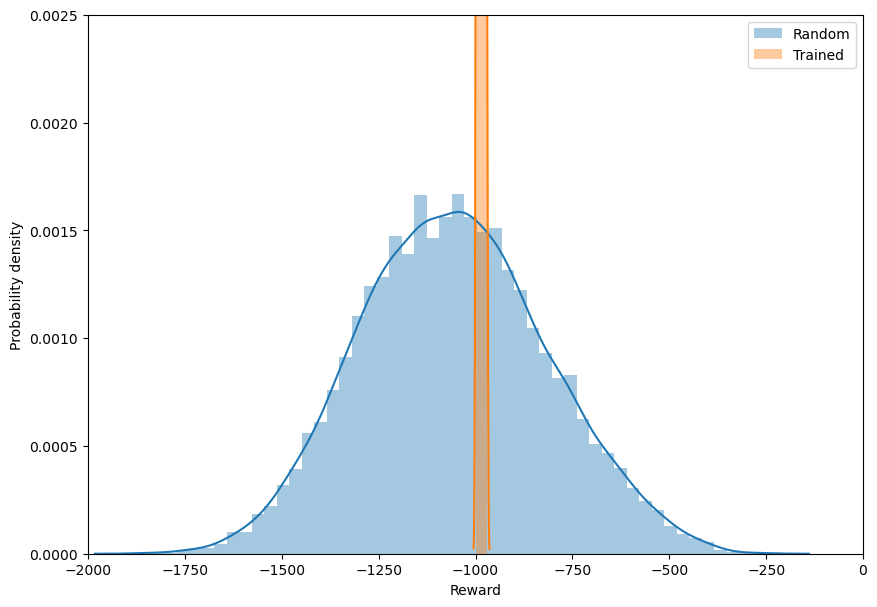

In [82]:
# Plot distribution of final rewards by random vs trained policy
final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # find final rewards
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
plt.ylabel('Probability density')
plt.xlabel('Reward')
plt.ylim(0,0.0025)
plt.xlim(-2000,0)
plt.legend()
# plt.savefig(fname = 'plots/reward_dist.png', dpi = 300)
plt.show()

# Closing the RL loop

In [15]:
num_iter = 1000 # No. of training iterations
epsilon  = 0.99   # Initial epsilon
replay_buffer = collections.deque(maxlen = 50000)

# for iteration in range(num_iter):
#     print('=========== TRAINING ITERATION %.0f ===========' % iteration)
#     print('Current epsilon = ', epsilon)

# Initialize env
env = MaterialEnvironment(element_set = element_set,
                              comp_set =  comp_set,)

# GENERATE EPISODES & ADD TO REPLAY BUFFER
print()

